# Refactor Network Charts 

Refactor network charts code to place geometry placement code in its own "mixin"...

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dmt.tk.plotting.shapes import Circle, Arc, PolarPoint
from dmt.tk.plotting.charts.network import CircularNetworkChart

In [2]:
N = 6
mtypes = ["L23_MC", "L5_TPC:A", "L6_UPC", "L23_BC", "L1_SBC", "L4_TPC"][:N]
sclasses = pd.Series(
    ["INH", "EXC", "EXC", "INH", "INH", "EXC"][:N],
    index=mtypes, name="sclass")
pathways = [
    (pre_mtype, post_mtype)
    for pre_mtype in mtypes
    for post_mtype in mtypes]
N = len(pathways)
pathway_strength = pd.DataFrame(
    {("pathway_strength", "mean"): np.random.uniform(size=N),
     ("pathway_strength", "std"):  np.random.uniform(size=N)},
    index=pd.MultiIndex.from_tuples(
        pathways,
        names=["pre_mtype", "post_mtype"]))
def get_node_weights(dataframe):
    weights = dataframe.groupby("pre_mtype").agg("sum")[("pathway_strength", "mean")]
    weights.index.name = "label"
    weights.name = "weight"
    return weights/np.sum(weights)

link_weights = pd.Series(
    pathway_strength[("pathway_strength", "mean")].values,
    index = pathway_strength.index.rename(["begin_node", "end_node"]),
    name="weight")

In [3]:
layer_cols = {'L1': np.array([0.3, 0.3, 0]),
              'L2': np.array([0.0, 0.3, 0.3]),
              'L3': np.array([0.15, 0.3, 0.15]),
              'L4': np.array([0.3, 0.0, 0.3]),
              'L5': np.array([0.0, 0.6, 0.0]),
              'L6': np.array([0.1, 0.1, 0.4])}
layer_cols["L23"] = (layer_cols["L2"] + layer_cols["L3"]) / 2.

default = np.array([0.2, 0.2, 0.2])
add_ei = {'EXC': np.array([0.5, 0.0, 0.0]),
          'INH': np.array([0.0, 0.0, 0.5])}


def _get_color(mtype, sclass):
    layer = mtype.split('_')[0]
    return np.minimum(
        layer_cols[layer]
            + add_ei[sclass] 
            + np.random.rand(3) * 0.25, 1.0)
def make_col_dict(mtypes):
    return dict([(_m[0], numpy.minimum(layer_cols.setdefault(_m[0][1], default)
                                       + add_ei[_m[1]] +
                                       numpy.random.rand(3) * 0.25, 1.0))
                 for _m in mtypes])

In [4]:
mtypes = link_weights.index.get_level_values("begin_node").unique()
color_map ={
    mtype: _get_color(mtype, sclass)
    for mtype, sclass in sclasses.items()}
for pre in mtypes:
    for post in mtypes:
        link_color = list(color_map[pre])
        link_color.append(0.25)
        color_map[(pre, post)] = np.array([0.8, 0.8, 0.8, 1.0]) * link_color
chart =\
    CircularNetworkChart(
        link_data=link_weights,
        color_map=color_map)

In [5]:
chart.link_data.groupby(
    "begin_node"
).agg(
    "sum"
).rename(
    "outgoing"
)

begin_node
L1_SBC      2.233039
L23_BC      3.257020
L23_MC      3.035355
L4_TPC      2.042997
L5_TPC:A    1.998202
L6_UPC      1.794688
Name: outgoing, dtype: float64

In [6]:
chart.node_flow

,outgoing,incoming,total
L1_SBC,2.233039,1.659612,3.892651
L23_BC,3.257020,2.320216,5.577236
L23_MC,3.035355,2.038193,5.073549
L4_TPC,2.042997,3.345619,5.388616
L5_TPC:A,1.998202,2.921155,4.919357
L6_UPC,1.794688,2.076505,3.871193


In [7]:
chart.node_weight

,total,source,target
L1_SBC,0.135526,0.077745,0.057781
L23_BC,0.194176,0.113396,0.080780
L23_MC,0.176640,0.105678,0.070961
L4_TPC,0.187609,0.071129,0.116480
L5_TPC:A,0.171271,0.069569,0.101702
L6_UPC,0.134779,0.062483,0.072295


In [8]:
chart.node_position

,source,target
L1_SBC,"(1.0, 0.18318238354520755)","(0.9, 0.5025073414817329)"
L23_BC,"(1.0, 1.1676316207877562)","(0.9, 1.6251476967152916)"
L23_MC,"(1.0, 2.3262794132202265)","(0.9, 2.742476629819709)"
L4_TPC,"(1.0, 3.339067383592712)","(0.9, 3.7811104642099345)"
L5_TPC:A,"(1.0, 4.481278243503409)","(0.9, 4.884826709489283)"
L6_UPC,"(1.0, 5.533479758257173)","(0.9, 5.851044451382878)"


In [9]:
chart.node_geometry_size.total

L1_SBC      (0.1, 0.6386499158730508)
L23_BC      (0.1, 0.9150321518550708)
L23_MC      (0.1, 0.8323944331989652)
L4_TPC      (0.1, 0.8840861612344458)
L5_TPC:A    (0.1, 0.8070969319717474)
L6_UPC        (0.1, 0.63512938625141)
Name: total, dtype: object

In [10]:
node_one = chart.node_data.iloc[0]
node_one.position.source

(1.0, 0.18318238354520755)

In [11]:
PolarPoint(
    *node_one.position.source)

PolarPoint(radial=1.0, angular=0.18318238354520755)

In [12]:
chart.get_source_geometry("L1_SBC", chart.node_data.loc["L1_SBC"])

In [13]:
chart.get_target_geometry("L1_SBC", chart.node_data.loc["L1_SBC"])

<Figure size 1008x1008 with 0 Axes>

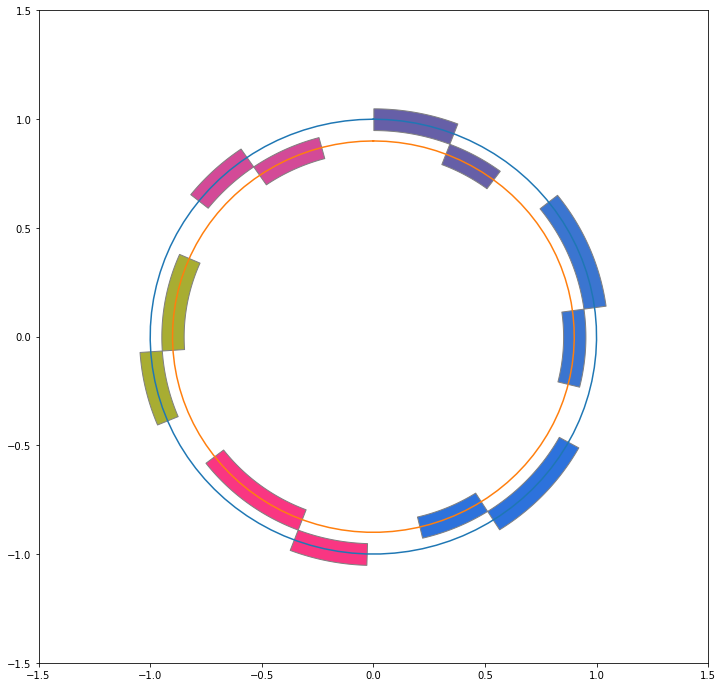

In [14]:
figure = plt.figure(figsize=(14, 14))
chart.draw(draw_diagonal=True)

In [15]:
def _angular_size(dataframe):
    return dataframe.apply(
        lambda row: pd.Series(dict(
            source = row.source[1],
            target = row.target[1])),
        axis=1
    )
posize = pd.concat(
    [_angular_size(chart.node_position),
     _angular_size(chart.node_geometry_size)],
    axis=1,
    keys=["position", "geometry_size"]
)
posize

position           geometry_size          
            source    target        source    target
L1_SBC    0.183182  0.502507      0.366365  0.272285
L23_BC    1.167632  1.625148      0.534365  0.380668
L23_MC    2.326279  2.742477      0.497997  0.334397
L4_TPC    3.339067  3.781110      0.335185  0.548901
L5_TPC:A  4.481278  4.884827      0.327836  0.479261
L6_UPC    5.533480  5.851044      0.294446  0.340683

In [16]:
posize.position.source

L1_SBC      0.183182
L23_BC      1.167632
L23_MC      2.326279
L4_TPC      3.339067
L5_TPC:A    4.481278
L6_UPC      5.533480
Name: source, dtype: float64

In [17]:
posize.position.source + posize.geometry_size.source/2 + posize.geometry_size.target/2

L1_SBC      0.502507
L23_BC      1.625148
L23_MC      2.742477
L4_TPC      3.781110
L5_TPC:A    4.884827
L6_UPC      5.851044
dtype: float64

In [18]:
l23_MC = chart.source_geometries["L23_MC"]
l23_MC.shape

PolarPoint(radial=(0.95, 1.05), angular=(2.0772808433264203, 2.5752779831140327))

In [19]:
chart.node_data.geometry_size.loc["L23_MC"].source

(0.1, 0.49799713978761223)

In [20]:
chart.center

array([0., 0.])

In [21]:
l23mc =  chart.source_geometries["L23_MC"]

In [22]:
l23mc.shape.radial

(0.95, 1.05)

In [23]:
l23mc.shape.angular

(2.0772808433264203, 2.5752779831140327)

In [24]:
chart.get_source_geometry(
    "L23_MC",
    chart.node_data.loc["L23_MC"]
).shape

PolarPoint(radial=(0.95, 1.05), angular=(2.0772808433264203, 2.5752779831140327))

In [25]:
chart.node_data.loc["L23_MC"]

position       source       (1.0, 2.3262794132202265)
               target        (0.9, 2.742476629819709)
geometry_size  total        (0.1, 0.8323944331989652)
               source      (0.1, 0.49799713978761223)
               target        (0.1, 0.334397293411353)
weight         total                          0.17664
               source                        0.105678
               target                       0.0709613
flow           outgoing                       3.03536
               incoming                       2.03819
               total                          5.07355
Name: L23_MC, dtype: object

In [26]:
PolarPoint(*chart.node_data.loc["L23_MC"].position.source)

PolarPoint(radial=1.0, angular=2.3262794132202265)

In [27]:
chart.node_geometry_size

,total,source,target
L1_SBC,"(0.1, 0.6386499158730508)","(0.1, 0.3663647670904151)","(0.1, 0.27228514878263566)"
L23_BC,"(0.1, 0.9150321518550708)","(0.1, 0.534364634231112)","(0.1, 0.38066751762395873)"
L23_MC,"(0.1, 0.8323944331989652)","(0.1, 0.49799713978761223)","(0.1, 0.334397293411353)"
L4_TPC,"(0.1, 0.8840861612344458)","(0.1, 0.335185438536354)","(0.1, 0.5489007226980918)"
L5_TPC:A,"(0.1, 0.8070969319717474)","(0.1, 0.3278360602905578)","(0.1, 0.4792608716811895)"
L6_UPC,"(0.1, 0.63512938625141)","(0.1, 0.2944464502562938)","(0.1, 0.34068293599511623)"


In [28]:
chart.node_geometry_size.apply(
    lambda s: pd.Series(dict(total=s.total[1], source=s.source[1], target=s.target[1])),
    axis=1)

,total,source,target
L1_SBC,0.638650,0.366365,0.272285
L23_BC,0.915032,0.534365,0.380668
L23_MC,0.832394,0.497997,0.334397
L4_TPC,0.884086,0.335185,0.548901
L5_TPC:A,0.807097,0.327836,0.479261
L6_UPC,0.635129,0.294446,0.340683


In [29]:
chart.node_position

,source,target
L1_SBC,"(1.0, 0.18318238354520755)","(0.9, 0.5025073414817329)"
L23_BC,"(1.0, 1.1676316207877562)","(0.9, 1.6251476967152916)"
L23_MC,"(1.0, 2.3262794132202265)","(0.9, 2.742476629819709)"
L4_TPC,"(1.0, 3.339067383592712)","(0.9, 3.7811104642099345)"
L5_TPC:A,"(1.0, 4.481278243503409)","(0.9, 4.884826709489283)"
L6_UPC,"(1.0, 5.533479758257173)","(0.9, 5.851044451382878)"


In [30]:
 number_nodes = chart.node_weight.shape[0]
 spacing = 2. * np.pi * chart.spacing_factor / number_nodes

 def _positions_angular():
     position_end = - spacing
     for size in chart.node_geometry_size.total.values:
         position_start = position_end + spacing
         position_end = position_start + size[1]
         yield (position_start + position_end) / 2.

positions_angular = pd.Series(
    list(_positions_angular()),
        index=chart.node_geometry_size.index,
        name="angular"
)
node_geometry_size_angular = chart.node_geometry_size.apply(
    lambda node_size: pd.Series(dict(
        total=node_size.total[1],
        source=node_size.source[1],
        target=node_size.target[1])),
        axis=1
)
starts_source = (
    positions_angular - node_geometry_size_angular.total[1] / 2.
).rename(
    "start_source"
)
positions_angular_source = (
    starts_source + node_geometry_size_angular.source[1] / 2.
).rename(
    "angular"
)
positions_source = positions_angular_source.apply(
    lambda position_angular: (chart.outer_circle.radius, position_angular)
)
starts_target = (
    positions_angular_source + node_geometry_size_angular.source[1] / 2.
).rename(
    "start_target"
)
positions_angular_target = (
    starts_target + node_geometry_size_angular.target[1] / 2.
).rename(
    "angular"
)
positions_target = positions_angular_target.apply(
    lambda position_angular: (
        chart.inner_circle.radius, position_angular)
)

In [31]:
positions_target

L1_SBC      (0.9, 0.5865072750520813)
L23_BC      (0.9, 1.6251476967152916)
L23_MC       (0.9, 2.760660377041459)
L4_TPC       (0.9, 3.880700062057314)
L5_TPC:A      (0.9, 4.98809099645956)
L6_UPC       (0.9, 5.971003543370288)
Name: angular, dtype: object